[NORM] No training stats found. Using robust Z-score.
[LOAD] TorchScript failed: PytorchStreamReader failed locating file constants.pkl: file not found
[REBUILD] Inferred arch [256, 16, 2] | missing=4 unexpected=4
[SHAP] GradientExplainer succeeded.
SHAP shape (target class): (8, 256)


/tmp/ipython-input-2955156729.py:214: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


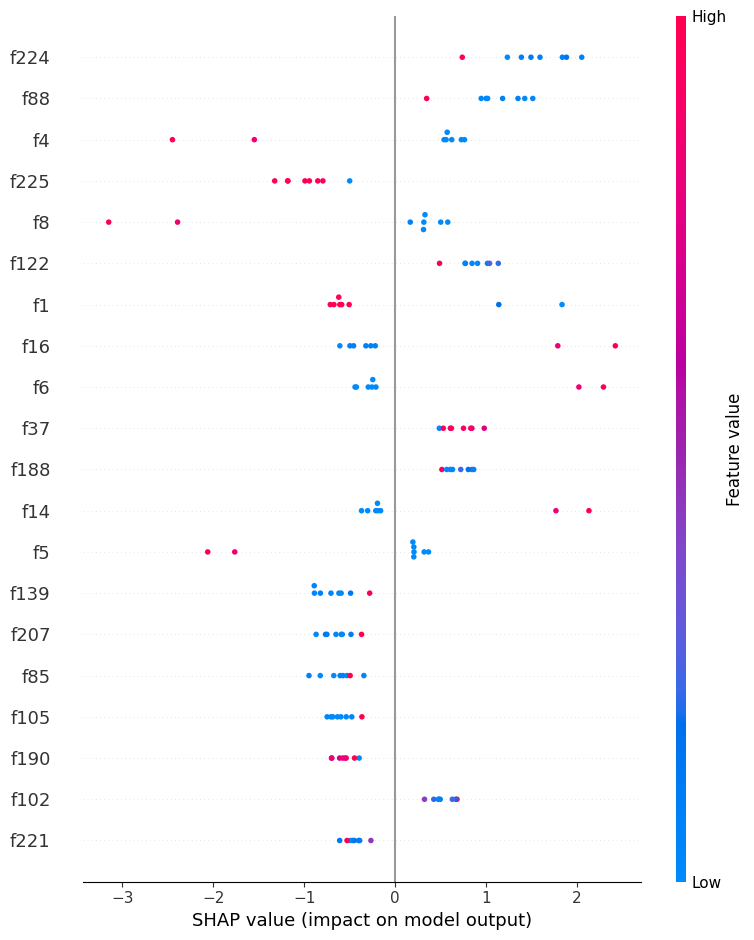

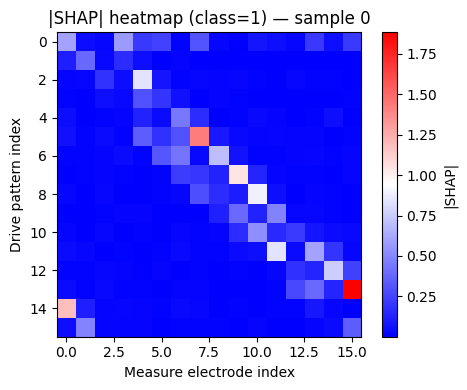

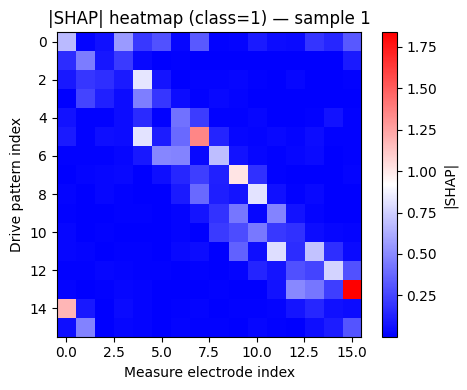

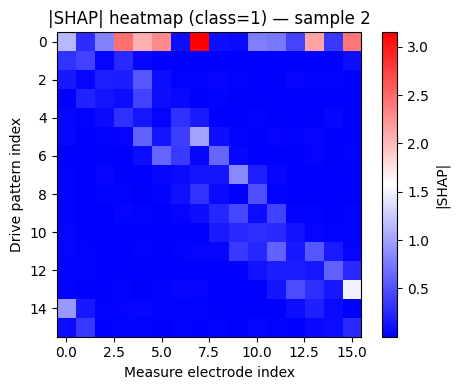

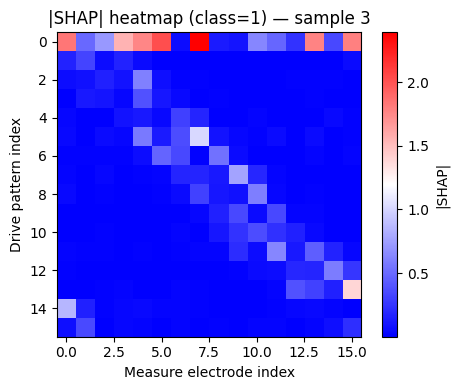

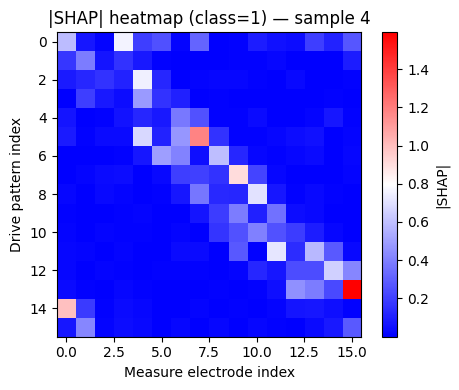

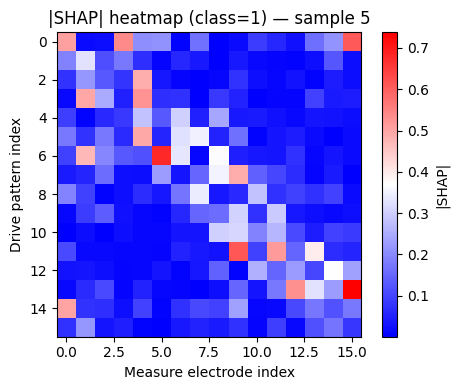

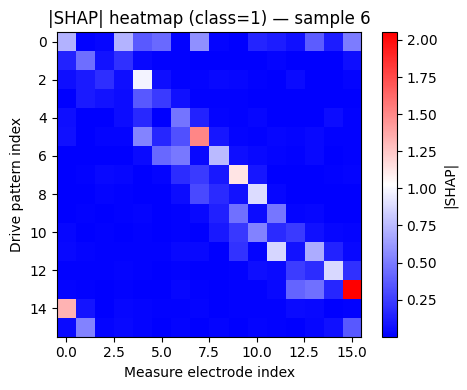

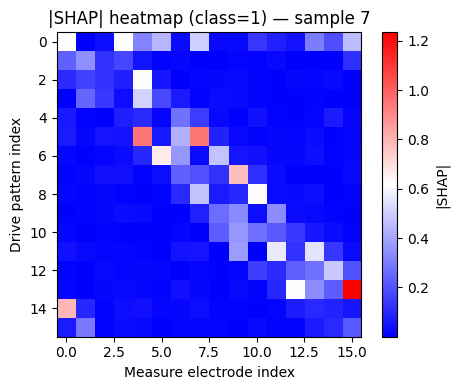

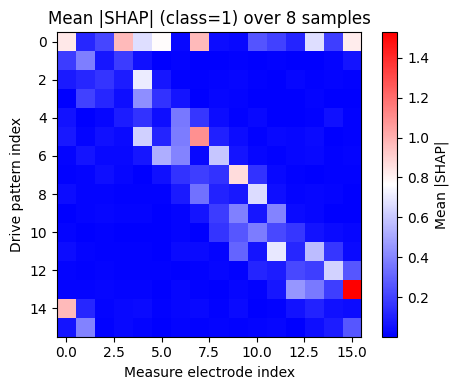

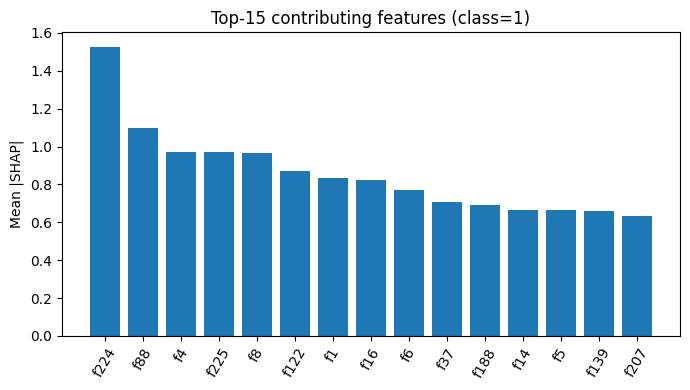

In [3]:
import os, numpy as np, pandas as pd, torch, torch.nn as nn
from collections import OrderedDict
import shap
import matplotlib.pyplot as plt

# -----------------------------
# CONFIG
# -----------------------------
X_FILE        = "/content/X_real_256.csv"
MODEL_PATH    = "/content/ann_anisotropy_classifier.pth"
STATS_FILES   = ["/mnt/data/train_stats_256.npz", "/mnt/data/train_stats_real_256.npz"]
USE_ROBUST_FALLBACK_IF_MISSING = True

CLASS_INDEX   = 1
N_EXPLAIN     = 8
BGN           = 128
SEED          = 42
DEVICE        = torch.device("cpu")

# -----------------------------
# Reproducibility
# -----------------------------
def set_seed(seed=SEED):
    import random
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
set_seed(SEED)

# -----------------------------
# Normalization helpers
# -----------------------------
def robust_zscore(X: np.ndarray) -> np.ndarray:
    med = np.median(X, axis=0, keepdims=True)
    mad = np.median(np.abs(X - med), axis=0, keepdims=True)
    scale = 1.4826 * mad
    return (X - med) / (scale + 1e-6)

def apply_training_normalization(X: np.ndarray) -> np.ndarray:
    for f in STATS_FILES:
        if os.path.exists(f):
            try:
                s = np.load(f)
                mean, std = s["mean"].reshape(1, -1), s["std"].reshape(1, -1)
                print(f"[NORM] Using training mean/std from: {f}")
                return (X - mean) / (std + 1e-6)
            except Exception as e:
                print(f"[WARN] Failed to read {f}: {e}")
    print("[NORM] No training stats found.",
          "Using robust Z-score." if USE_ROBUST_FALLBACK_IF_MISSING else "No normalization.")
    return robust_zscore(X) if USE_ROBUST_FALLBACK_IF_MISSING else X

# -----------------------------
# Model loaders
# -----------------------------
class GenericMLP(nn.Module):
    def __init__(self, sizes):
        super().__init__()
        layers = []
        for i in range(len(sizes)-1):
            layers.append(nn.Linear(sizes[i], sizes[i+1]))
            if i < len(sizes)-2:
                layers += [nn.ReLU()]
        self.net = nn.Sequential(*layers)
    def forward(self, x): return self.net(x)

def reconstruct_from_state_dict(sd, input_dim=256, default_out=2):
    # infer chain of Linear layers from weight shapes (out,in)
    lin = [(k, v) for k, v in sd.items() if k.endswith("weight") and v.ndim == 2]
    # map in_features -> [out_features]
    fmap = {}
    for k, w in lin:
        out_f, in_f = w.shape
        fmap.setdefault(in_f, set()).add(out_f)
    chain = [input_dim]
    cur = input_dim
    # greedy build up to 5 layers
    for _ in range(5):
        if cur not in fmap: break
        outs = sorted(list(fmap[cur]))
        nxt = outs[-1]
        chain.append(nxt)
        cur = nxt
        if nxt == default_out: break
    if chain[-1] != default_out:
        chain.append(default_out)
    model = GenericMLP(chain)
    missing = model.load_state_dict(sd, strict=False)
    print(f"[REBUILD] Inferred arch {chain} | missing={len(missing.missing_keys)} unexpected={len(missing.unexpected_keys)}")
    return model

def load_model_safely(path: str, device=DEVICE) -> nn.Module:
    # 1) TorchScript
    try:
        m = torch.jit.load(path, map_location=device)
        m.eval()
        print("[LOAD] TorchScript model loaded.")
        return m
    except Exception as e:
        print(f"[LOAD] TorchScript failed: {e}")
    # 2) Pickled nn.Module or dict
    obj = torch.load(path, map_location=device)
    if isinstance(obj, nn.Module):
        obj.eval(); print("[LOAD] Pickled nn.Module loaded."); return obj
    if isinstance(obj, dict):
        # common formats: {"state_dict": ...} or raw state_dict
        sd = obj.get("state_dict", obj)
        if isinstance(sd, OrderedDict) or isinstance(sd, dict):
            # Legacy off-by-one key index fix (your earlier script remapped .3 -> .2)
            remap = OrderedDict()
            for k, v in sd.items():
                remap[k.replace("network.3.", "network.2.")] = v
            sd = remap
            model = reconstruct_from_state_dict(sd, input_dim=256, default_out=2)
            model.eval()
            return model
    raise RuntimeError("Unrecognized checkpoint format.")

# -----------------------------
# Load data & model
# -----------------------------
X_raw = pd.read_csv(X_FILE, header=None).to_numpy(np.float32)
assert X_raw.shape[1] == 256, f"Expected 256 features, got {X_raw.shape[1]}"
X = apply_training_normalization(X_raw)

model = load_model_safely(MODEL_PATH, device=DEVICE).to(DEVICE)
model.eval()

# -----------------------------
# Select background & explain set
# -----------------------------
rng = np.random.default_rng(SEED)
idx_bg = rng.choice(len(X), size=min(BGN, len(X)), replace=False)
idx_ex = np.arange(min(N_EXPLAIN, len(X)))
X_bg = X[idx_bg]
X_ex = X[idx_ex]

X_bg_t = torch.tensor(X_bg, dtype=torch.float32, device=DEVICE, requires_grad=True)
X_ex_t = torch.tensor(X_ex, dtype=torch.float32, device=DEVICE, requires_grad=True)

# -----------------------------
# SHAP: Gradient first, Kernel fallback
# -----------------------------
def ensure_numpy(arr):
    return arr.detach().cpu().numpy() if torch.is_tensor(arr) else np.asarray(arr)

def run_gradient_explainer():
    # SHAP expects outputs; we’ll let it hook the model directly
    explainer = shap.GradientExplainer(model, X_bg_t)
    shap_vals = explainer.shap_values(X_ex_t)  # list or array depending on SHAP version
    # Normalize output shape to [N, F] for target class
    if isinstance(shap_vals, (list, tuple)):
        # list length = number of outputs; take CLASS_INDEX
        sv = shap_vals[CLASS_INDEX]
    else:
        # array shape [N, F, C] or [C, N, F]
        sv = np.array(shap_vals)
        if sv.ndim == 3 and sv.shape[-1] > 1:    # [N,F,C]
            sv = sv[..., CLASS_INDEX]
        elif sv.ndim == 3 and sv.shape[0] > 1:   # [C,N,F]
            sv = sv[CLASS_INDEX]
    sv = np.asarray(sv)
    assert sv.shape[0] == X_ex.shape[0] and sv.shape[1] == X_ex.shape[1]
    print("[SHAP] GradientExplainer succeeded.")
    return sv

def run_kernel_explainer():
    # KernelExplainer needs a function f(np)->prob for class=CLASS_INDEX
    @torch.no_grad()
    def f_np(x_np: np.ndarray) -> np.ndarray:
        xt = torch.tensor(x_np, dtype=torch.float32, device=DEVICE)
        logits = model(xt)
        if logits.ndim == 1 or logits.shape[1] == 1:
            p1 = torch.sigmoid(logits.view(-1)).cpu().numpy()
            # Map to class prob for CLASS_INDEX
            p = p1 if CLASS_INDEX == 1 else (1.0 - p1)
        else:
            p = torch.softmax(logits, dim=1)[:, CLASS_INDEX].cpu().numpy()
        return p
    # Use a small background for speed
    bg_small = X_bg[: min(64, len(X_bg))]
    explainer = shap.KernelExplainer(f_np, bg_small, link="identity")
    # nsamples="auto" keeps things tractable
    sv = explainer.shap_values(X_ex, nsamples="auto")
    # KernelExplainer returns (N, F)
    sv = np.asarray(sv)
    if sv.ndim == 3:
        sv = sv[CLASS_INDEX]
    print("[SHAP] KernelExplainer fallback used.")
    return sv

try:
    shap_class = run_gradient_explainer()
except Exception as e:
    print(f"[SHAP] GradientExplainer failed: {e}")
    shap_class = run_kernel_explainer()

print("SHAP shape (target class):", shap_class.shape)

# -----------------------------
# PLOTS
# -----------------------------
feature_names = [f"f{i+1}" for i in range(256)]

# 1) SHAP summary (beeswarm)
try:
    shap.summary_plot(
        shap_class, X_ex,
        feature_names=feature_names,
        show=True
    )
except Exception as e:
    print(f"[WARN] summary_plot failed: {e}")

# 2) Per-sample 16x16 |SHAP| heatmaps
for i in range(min(N_EXPLAIN, shap_class.shape[0])):
    mat = np.abs(shap_class[i]).reshape(16, 16)
    plt.figure(figsize=(5, 4))
    plt.imshow(mat, cmap="bwr", aspect="equal")
    plt.colorbar(label="|SHAP|")
    plt.title(f"|SHAP| heatmap (class={CLASS_INDEX}) — sample {i}")
    plt.xlabel("Measure electrode index")
    plt.ylabel("Drive pattern index")
    plt.tight_layout()
    plt.show()

# 3) Mean |SHAP| over explained samples (16×16)
mean_abs = np.mean(np.abs(shap_class), axis=0).reshape(16, 16)
plt.figure(figsize=(5, 4))
plt.imshow(mean_abs, cmap="bwr", aspect="equal")
plt.colorbar(label="Mean |SHAP|")
plt.title(f"Mean |SHAP| (class={CLASS_INDEX}) over {shap_class.shape[0]} samples")
plt.xlabel("Measure electrode index")
plt.ylabel("Drive pattern index")
plt.tight_layout()
plt.show()

# 4) Top-k features bar plot
TOPK = 15
mean_abs_flat = np.mean(np.abs(shap_class), axis=0)
top_idx = np.argsort(-mean_abs_flat)[:TOPK]
plt.figure(figsize=(7, 4))
plt.bar(range(TOPK), mean_abs_flat[top_idx])
plt.xticks(range(TOPK), [feature_names[j] for j in top_idx], rotation=60)
plt.ylabel("Mean |SHAP|")
plt.title(f"Top-{TOPK} contributing features (class={CLASS_INDEX})")
plt.tight_layout()
plt.show()


In [4]:
pip install captum==0.7.0


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 75.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 60.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 38.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 83.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12


[NORM] No training stats found. Using robust Z-score.
[LOAD] TorchScript failed: PytorchStreamReader failed locating file constants.pkl: file not found
[REBUILD] Inferred arch [256, 16, 2] | missing=4 unexpected=4
[SALIENCY] abs |∂f/∂x| shape: (6, 256)


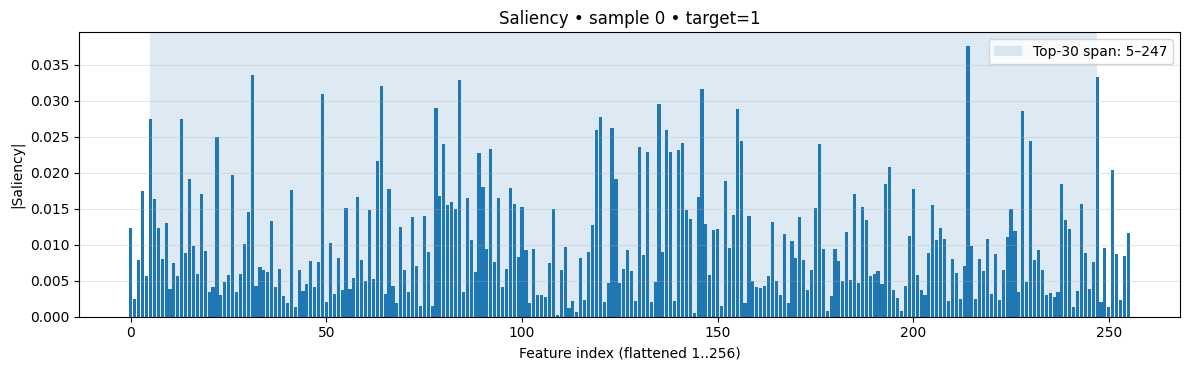

[INFO] Sample 0: top-30 indices -> [5, 13, 22, 31, 49, 63, 64, 78, 80, 84, 89, 92, 119, 120, 123, 130, 132, 135, 137, 138, 140, 141, 146, 155, 156, 176, 214, 228, 230, 247]


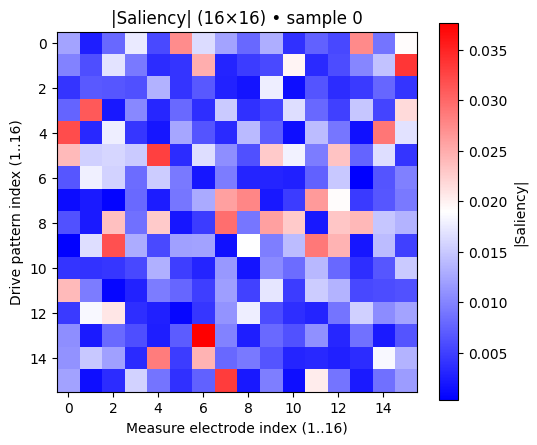

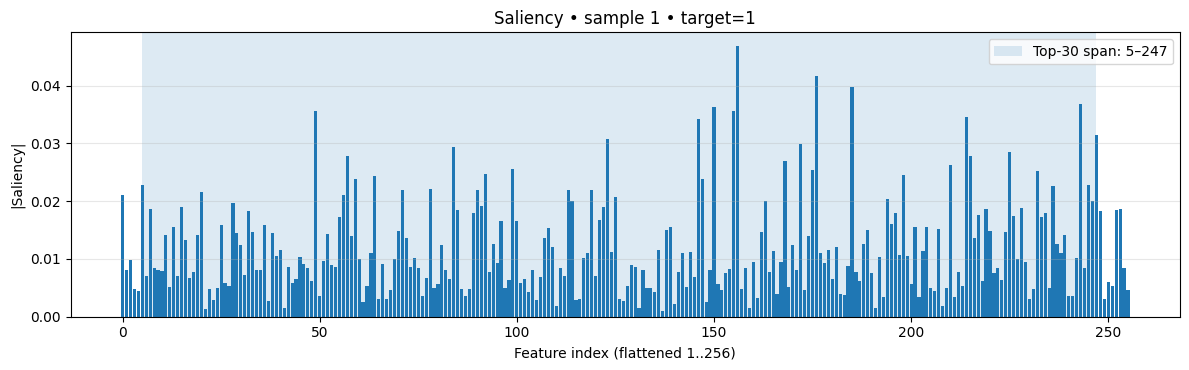

[INFO] Sample 1: top-30 indices -> [5, 49, 57, 59, 64, 78, 84, 92, 99, 123, 146, 147, 150, 155, 156, 168, 172, 175, 176, 185, 198, 210, 214, 215, 225, 232, 236, 243, 245, 247]


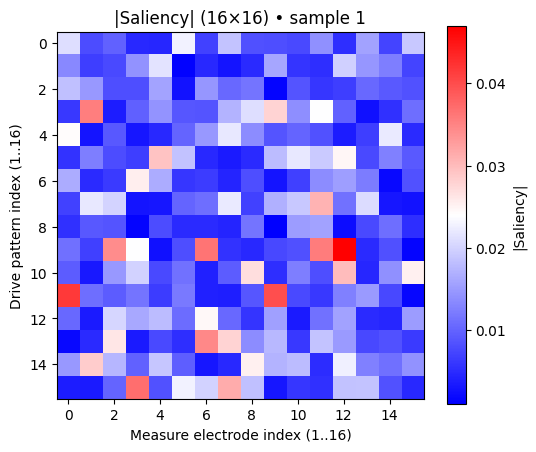

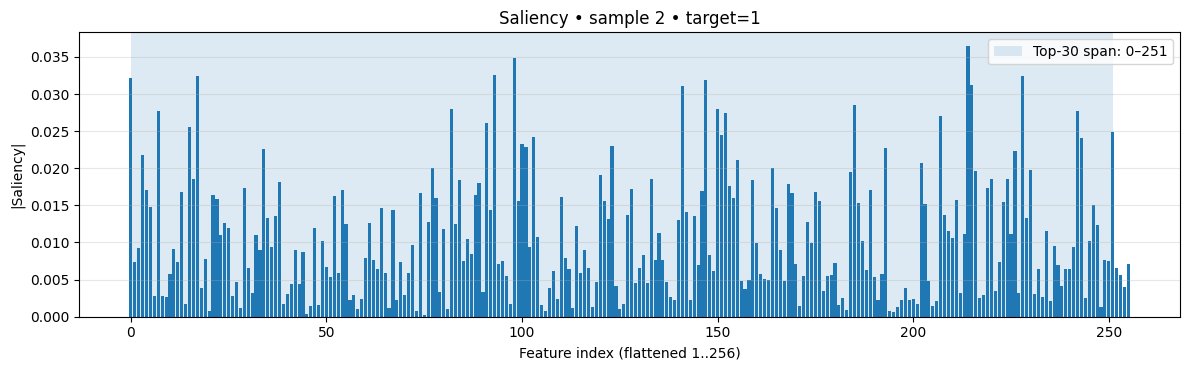

[INFO] Sample 2: top-30 indices -> [0, 3, 7, 15, 17, 34, 82, 91, 93, 98, 100, 101, 103, 123, 141, 147, 150, 151, 152, 155, 185, 193, 207, 214, 215, 226, 228, 242, 243, 251]


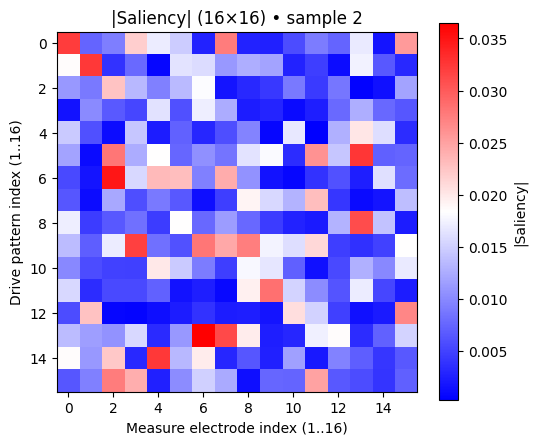

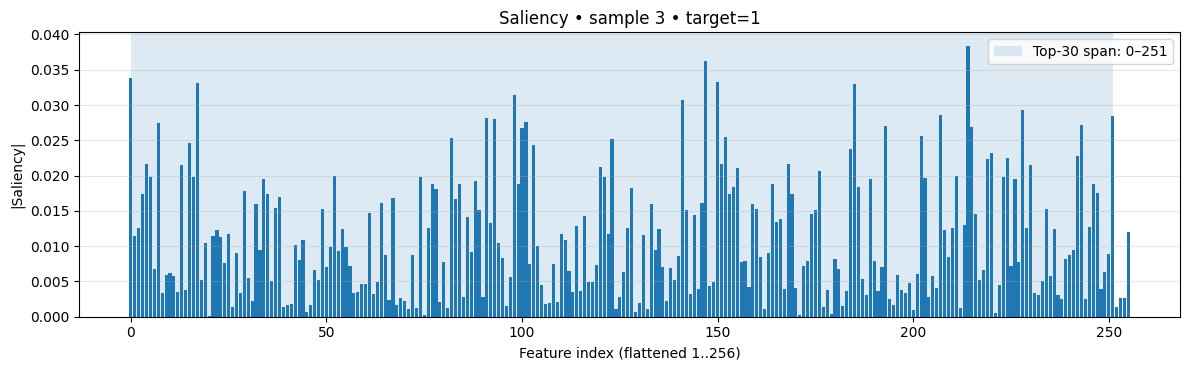

[INFO] Sample 3: top-30 indices -> [0, 7, 15, 17, 82, 91, 93, 98, 100, 101, 103, 123, 141, 147, 150, 152, 184, 185, 193, 202, 207, 214, 215, 219, 220, 224, 228, 242, 243, 251]


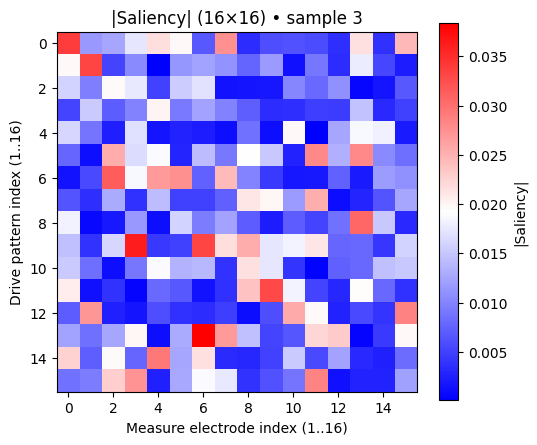

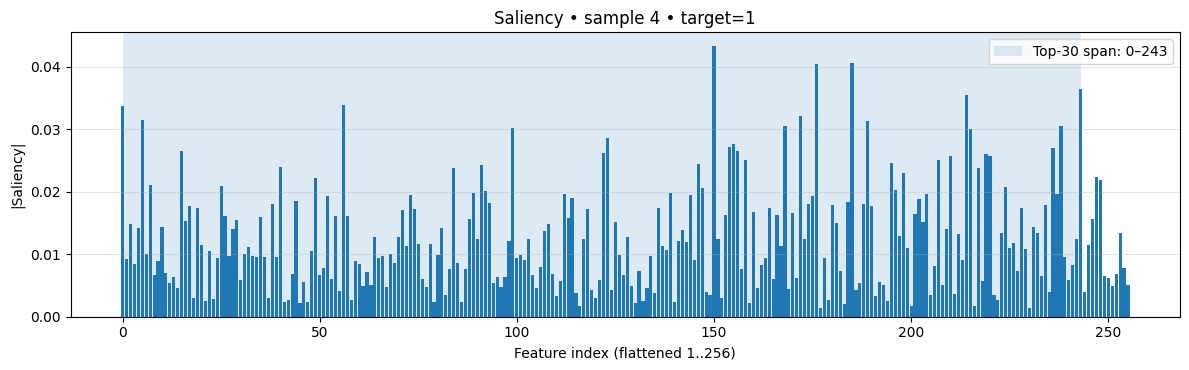

[INFO] Sample 4: top-30 indices -> [0, 5, 15, 40, 56, 91, 99, 122, 123, 146, 150, 154, 155, 156, 158, 168, 172, 176, 185, 189, 195, 207, 210, 214, 215, 219, 220, 236, 238, 243]


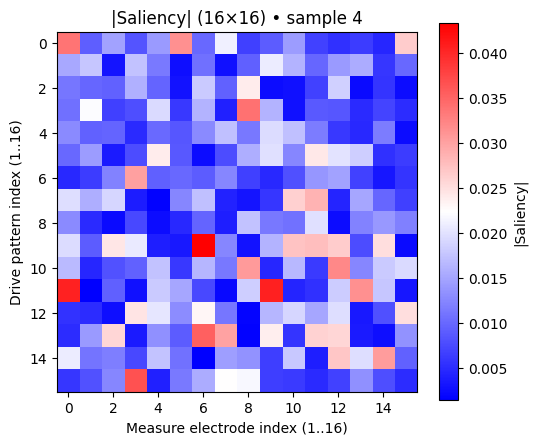

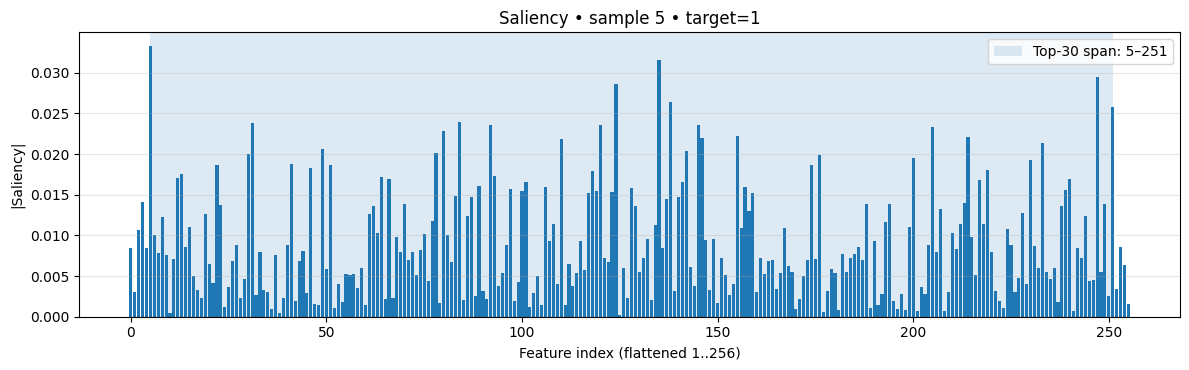

[INFO] Sample 5: top-30 indices -> [5, 22, 30, 31, 41, 46, 49, 51, 78, 80, 84, 92, 110, 120, 124, 135, 138, 142, 145, 146, 155, 174, 176, 200, 205, 214, 230, 233, 247, 251]


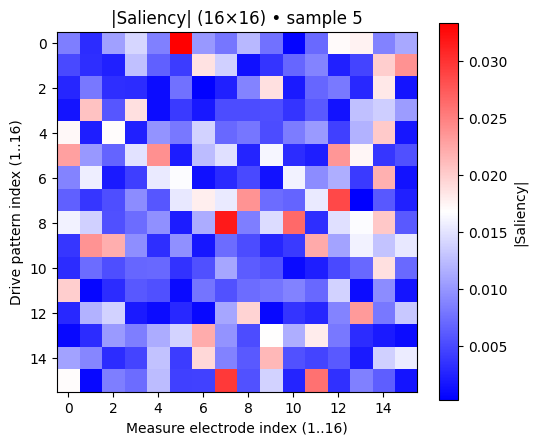

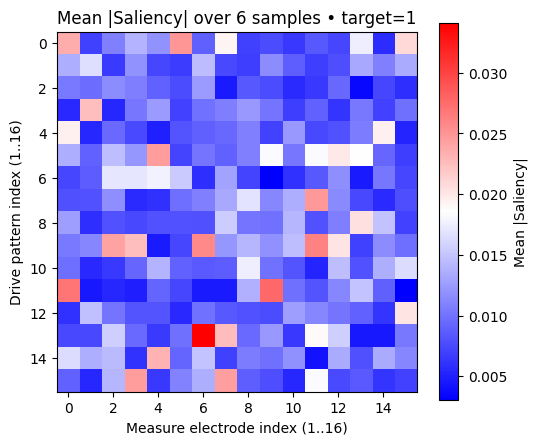

In [6]:
# === Saliency (Captum) for EIT Anisotropy ANN — robust, batch-friendly ===
import os, numpy as np, pandas as pd, torch, torch.nn as nn
import matplotlib.pyplot as plt
from collections import OrderedDict
from captum.attr import Saliency
from typing import Optional, Tuple

# -----------------------------
# CONFIG
# -----------------------------
X_FILE        = "/content/X_real_256.csv"     # or "/mnt/data/X_balanced.csv"
MODEL_PATH    = "/content/ann_anisotropy_classifier.pth"
STATS_FILES   = ["/mnt/data/train_stats_256.npz", "/mnt/data/train_stats_real_256.npz"]

TARGET_CLASS  = 1        # saliency target: 1 = anisotropy, 0 = isotropy
SAMPLE_IDX    = 0        # starting index
N_EXPLAIN     = 6        # number of consecutive samples to explain
TOP_K         = 30       # highlight top-K features in bar chart
USE_SMOOTHGRAD = True    # average multiple noisy gradients for smoother maps
SG_SAMPLES     = 20      # number of noise samples for SmoothGrad
SG_NOISE_STD   = 0.10    # noise std in normalized feature space

SAVE_DIR      = None     # e.g., "/mnt/data/saliency_figs" to save plots
DEVICE        = torch.device("cpu")
SEED          = 42
# -----------------------------

# Reproducibility
def set_seed(seed=SEED):
    import random
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
set_seed(SEED)

# ------------ Normalization ------------
def robust_zscore(X: np.ndarray) -> np.ndarray:
    med = np.median(X, axis=0, keepdims=True)
    mad = np.median(np.abs(X - med), axis=0, keepdims=True)
    scale = 1.4826 * mad
    return (X - med) / (scale + 1e-6)

def apply_training_normalization(X: np.ndarray) -> np.ndarray:
    for f in STATS_FILES:
        if os.path.exists(f):
            try:
                s = np.load(f)
                mean = s["mean"].reshape(1, -1).astype(np.float32)
                std  = s["std"].reshape(1, -1).astype(np.float32)
                print(f"[NORM] Using training mean/std from {f}")
                return (X - mean) / (std + 1e-6)
            except Exception as e:
                print(f"[WARN] Failed reading {f}: {e}")
    print("[NORM] No training stats found. Using robust Z-score.")
    return robust_zscore(X)

# ------------ Model loading (robust) ------------
class GenericMLP(nn.Module):
    def __init__(self, sizes):
        super().__init__()
        layers = []
        for i in range(len(sizes)-1):
            layers.append(nn.Linear(sizes[i], sizes[i+1]))
            if i < len(sizes)-2:
                layers.append(nn.ReLU())
        self.net = nn.Sequential(*layers)
    def forward(self, x): return self.net(x)

def reconstruct_from_state_dict(sd, input_dim=256, default_out=2):
    lin = [(k, v) for k, v in sd.items() if k.endswith("weight") and v.ndim == 2]
    fmap = {}
    for k, w in lin:
        out_f, in_f = w.shape
        fmap.setdefault(in_f, set()).add(out_f)
    chain = [input_dim]; cur = input_dim
    for _ in range(5):  # cap at 5 linear layers
        if cur not in fmap: break
        nxt = max(fmap[cur])
        chain.append(nxt); cur = nxt
        if nxt == default_out: break
    if chain[-1] != default_out: chain.append(default_out)
    model = GenericMLP(chain)
    missing = model.load_state_dict(sd, strict=False)
    print(f"[REBUILD] Inferred arch {chain} | missing={len(missing.missing_keys)} unexpected={len(missing.unexpected_keys)}")
    return model

def load_model_safely(path: str, device=DEVICE) -> nn.Module:
    # TorchScript
    try:
        m = torch.jit.load(path, map_location=device)
        m.eval(); print("[LOAD] TorchScript model loaded."); return m
    except Exception as e:
        print(f"[LOAD] TorchScript failed: {e}")
    # nn.Module or state_dict
    obj = torch.load(path, map_location=device)
    if isinstance(obj, nn.Module):
        obj.eval(); print("[LOAD] Pickled nn.Module loaded."); return obj
    if isinstance(obj, dict):
        sd = obj.get("state_dict", obj)
        # legacy key fix: network.3.* -> network.2.*
        remap = OrderedDict((k.replace("network.3.", "network.2."), v) for k, v in sd.items())
        model = reconstruct_from_state_dict(remap, input_dim=256, default_out=2)
        model.eval(); return model
    raise RuntimeError("Unrecognized checkpoint format.")

# ------------ Data ------------
X_raw = pd.read_csv(X_FILE, header=None).to_numpy(np.float32)
assert X_raw.shape[1] == 256, f"Expected 256 features, got {X_raw.shape[1]}"
X = apply_training_normalization(X_raw)

# Select batch to explain
end_idx = min(SAMPLE_IDX + N_EXPLAIN, len(X))
assert SAMPLE_IDX < end_idx, "No samples selected to explain."
X_explain = X[SAMPLE_IDX:end_idx]           # [N, 256]
X_explain_t = torch.tensor(X_explain, dtype=torch.float32, device=DEVICE, requires_grad=True)

# Load model
model = load_model_safely(MODEL_PATH, device=DEVICE).to(DEVICE)

# ------------ Saliency core ------------
saliency = Saliency(model)

@torch.no_grad()
def predict_logits(x: torch.Tensor) -> torch.Tensor:
    return model(x)

def compute_saliency(
    x: torch.Tensor,
    target: int,
    use_smoothgrad: bool = False,
    sg_samples: int = 20,
    sg_noise_std: float = 0.10
) -> np.ndarray:
    """
    Returns |saliency| as a numpy array [N, 256].
    SmoothGrad: average |∂f/∂x| over noisy copies of x.
    """
    if not use_smoothgrad:
        attrs = saliency.attribute(x, target=target)       # [N,256]
        return np.abs(attrs.detach().cpu().numpy())

    # SmoothGrad
    N = x.shape[0]
    acc = np.zeros((N, x.shape[1]), dtype=np.float32)
    for _ in range(sg_samples):
        noise = torch.randn_like(x) * sg_noise_std
        noisy = (x + noise).clone().detach().requires_grad_(True)
        attrs = saliency.attribute(noisy, target=target)
        acc += np.abs(attrs.detach().cpu().numpy())
    return acc / float(sg_samples)

# Compute |saliency|
abs_sal = compute_saliency(
    X_explain_t, target=TARGET_CLASS,
    use_smoothgrad=USE_SMOOTHGRAD, sg_samples=SG_SAMPLES, sg_noise_std=SG_NOISE_STD
)  # shape [N,256]
print(f"[SALIENCY] abs |∂f/∂x| shape: {abs_sal.shape}")

# ------------ Plot helpers ------------
def maybe_save(fig, fname: str):
    if SAVE_DIR:
        os.makedirs(SAVE_DIR, exist_ok=True)
        path = os.path.join(SAVE_DIR, fname)
        fig.savefig(path, dpi=160, bbox_inches="tight")
        print(f"[SAVE] {path}")

def plot_bar_with_span(abs_attr: np.ndarray, idx0: int, top_k: int = 30):
    top_idx = np.argsort(abs_attr)[-top_k:]
    span_min, span_max = int(top_idx.min()), int(top_idx.max())
    fig = plt.figure(figsize=(12, 3.8))
    plt.bar(np.arange(256), abs_attr)
    plt.axvspan(span_min, span_max, alpha=0.15, label=f"Top-{top_k} span: {span_min}–{span_max}")
    plt.xlabel("Feature index (flattened 1..256)")
    plt.ylabel("|Saliency|")
    plt.title(f"Saliency • sample {SAMPLE_IDX + idx0} • target={TARGET_CLASS}")
    plt.legend(); plt.grid(True, axis="y", alpha=0.3); plt.tight_layout(); plt.show()
    maybe_save(fig, f"saliency_bar_sample{SAMPLE_IDX+idx0}.png")
    print(f"[INFO] Sample {SAMPLE_IDX+idx0}: top-{top_k} indices ->", np.sort(top_idx).tolist())

def plot_heatmap_16x16(abs_attr: np.ndarray, idx0: int, title_prefix: str):
    heat = abs_attr.reshape(16, 16)
    fig = plt.figure(figsize=(5.5, 4.6))
    im = plt.imshow(heat, cmap="bwr", aspect="equal")
    plt.colorbar(im, label="|Saliency|")
    plt.title(f"{title_prefix} • sample {SAMPLE_IDX + idx0}")
    plt.xlabel("Measure electrode index (1..16)")
    plt.ylabel("Drive pattern index (1..16)")
    plt.tight_layout(); plt.show()
    maybe_save(fig, f"saliency_heatmap_sample{SAMPLE_IDX+idx0}.png")

# ------------ Per-sample plots ------------
for i in range(abs_sal.shape[0]):
    plot_bar_with_span(abs_sal[i], idx0=i, top_k=TOP_K)
    plot_heatmap_16x16(abs_sal[i], idx0=i, title_prefix="|Saliency| (16×16)")

# ------------ Mean heatmap across explained batch ------------
mean_abs = abs_sal.mean(axis=0).reshape(16, 16)
fig = plt.figure(figsize=(5.5, 4.6))
im = plt.imshow(mean_abs, cmap="bwr", aspect="equal")
plt.colorbar(im, label="Mean |Saliency|")
plt.title(f"Mean |Saliency| over {abs_sal.shape[0]} samples • target={TARGET_CLASS}")
plt.xlabel("Measure electrode index (1..16)")
plt.ylabel("Drive pattern index (1..16)")
plt.tight_layout(); plt.show()
maybe_save(fig, f"saliency_mean_heatmap_{abs_sal.shape[0]}samples.png")


[NORM] No training stats found. Using robust Z-score.


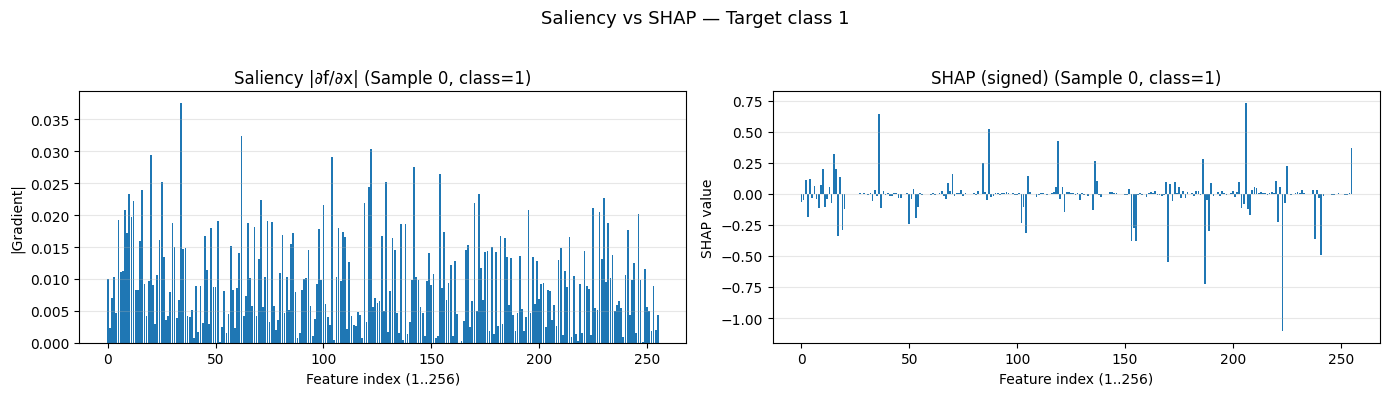

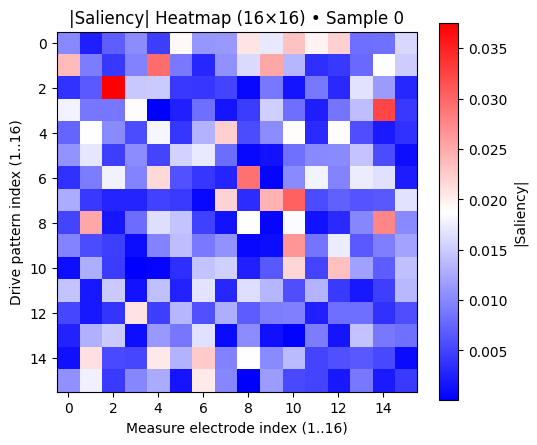

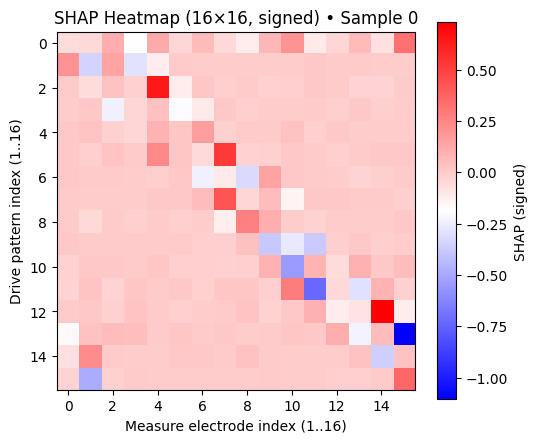

In [8]:
# === Saliency + SHAP comparison for EIT ANN (single sample) ===
# - Loads your pretrained model (state_dict with legacy key fix)
# - Applies training mean/std if available; else robust Z-score
# - Computes Captum Saliency (|∂f/∂x|) and SHAP (GradientExplainer)
# - Plots bar charts side-by-side + optional 16×16 heatmaps

import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from collections import OrderedDict
from captum.attr import Saliency
import shap

# -----------------------------
# CONFIG
# -----------------------------
X_FILE      = "/content/X_real_256.csv"   # or /mnt/data/X_balanced.csv
MODEL_PATH  = "/content/ann_anisotropy_classifier.pth"
STATS_FILES = ["/mnt/data/train_stats_256.npz", "/mnt/data/train_stats_real_256.npz"]

SAMPLE_IDX   = 0       # sample to explain
TARGET_CLASS = 1       # 1 = anisotropic (change to 0 for isotropy)
BGN          = 128     # SHAP background size
PLOT_HEATMAP = True    # also show 16×16 heatmaps

DEVICE = torch.device("cpu")
SEED   = 42

# -----------------------------
# Reproducibility
# -----------------------------
def set_seed(seed=SEED):
    import random
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
set_seed(SEED)

# -----------------------------
# Normalization
# -----------------------------
def robust_zscore(X: np.ndarray) -> np.ndarray:
    med = np.median(X, axis=0, keepdims=True)
    mad = np.median(np.abs(X - med), axis=0, keepdims=True)
    scale = 1.4826 * mad
    return (X - med) / (scale + 1e-6)

def apply_training_normalization(X: np.ndarray) -> np.ndarray:
    for f in STATS_FILES:
        if os.path.exists(f):
            try:
                s = np.load(f)
                mean = s["mean"].reshape(1, -1).astype(np.float32)
                std  = s["std"].reshape(1, -1).astype(np.float32)
                print(f"[NORM] Using training mean/std from {f}")
                return (X - mean) / (std + 1e-6)
            except Exception as e:
                print(f"[WARN] Failed reading {f}: {e}")
    print("[NORM] No training stats found. Using robust Z-score.")
    return robust_zscore(X)

# -----------------------------
# Model loader (robust to legacy key names)
# -----------------------------
class AnisotropyClassifier(nn.Module):
    def __init__(self, in_features=256, hidden=16, num_classes=2):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(in_features, hidden),
            nn.ReLU(),
            nn.Linear(hidden, num_classes),
        )
    def forward(self, x):
        return self.network(x)

def load_remapped_model(path: str, device=DEVICE) -> nn.Module:
    raw = torch.load(path, map_location="cpu")
    sd = raw.get("state_dict", raw)
    if not isinstance(sd, dict):
        raise RuntimeError("Unexpected checkpoint format (no state_dict).")
    # Legacy fix: "network.3.*" -> "network.2.*"
    new_sd = OrderedDict((k.replace("network.3.", "network.2."), v) for k, v in sd.items())
    in_features  = new_sd["network.0.weight"].shape[1]
    hidden       = new_sd["network.0.weight"].shape[0]
    out_features = new_sd["network.2.weight"].shape[0]
    model = AnisotropyClassifier(in_features, hidden, out_features).to(device)
    model.load_state_dict(new_sd, strict=True)
    model.eval()
    return model

# -----------------------------
# Load & normalize data
# -----------------------------
X_real = pd.read_csv(X_FILE, header=None).to_numpy(dtype=np.float32)
assert X_real.shape[1] == 256, f"Expected 256 features, got {X_real.shape[1]}"
X_norm = apply_training_normalization(X_real)

assert 0 <= SAMPLE_IDX < len(X_norm), "SAMPLE_IDX out of range."
rng = np.random.default_rng(SEED)
bg_idx = rng.choice(len(X_norm), size=min(BGN, len(X_norm)), replace=False)
X_bg   = X_norm[bg_idx]
x1     = X_norm[SAMPLE_IDX:SAMPLE_IDX+1]  # [1,256]

sample_t = torch.tensor(x1,   dtype=torch.float32, device=DEVICE, requires_grad=True)
bg_t     = torch.tensor(X_bg, dtype=torch.float32, device=DEVICE)

# -----------------------------
# Load model
# -----------------------------
model = load_remapped_model(MODEL_PATH, device=DEVICE)

# -----------------------------
# Captum Saliency
# -----------------------------
saliency = Saliency(model)
sal_attr = saliency.attribute(sample_t, target=TARGET_CLASS)   # [1,256]
sal_attr = sal_attr.squeeze(0).detach().cpu().numpy()
sal_abs  = np.abs(sal_attr)

# -----------------------------
# SHAP (GradientExplainer with shape guard)
# -----------------------------
explainer = shap.GradientExplainer(model, bg_t)
sv_raw = explainer.shap_values(sample_t)   # list or array depending on SHAP version

# Normalize SHAP output to 1D vector for the target class
def extract_sv_for_class(shap_out, target=1):
    arr = np.array(shap_out, dtype=object)
    # Cases:
    # 1) list of length C -> pick shap_out[target]: shape [N,F]
    if isinstance(shap_out, (list, tuple)) and len(shap_out) > 1:
        sv = np.asarray(shap_out[target])
        return sv.reshape(-1, sv.shape[-1])[0]  # 1D features
    # 2) array [N,F,C] -> take class dim
    arr = np.array(shap_out)
    if arr.ndim == 3 and arr.shape[-1] > 1:
        return arr[0, :, target]
    # 3) array [C,N,F] -> take class first
    if arr.ndim == 3 and arr.shape[0] > 1:
        return arr[target, 0, :]
    # 4) array [N,F] (binary simplified) -> directly first row
    if arr.ndim == 2:
        return arr[0]
    raise RuntimeError(f"Unexpected SHAP shape: {arr.shape}")

shap_attr = extract_sv_for_class(sv_raw, target=TARGET_CLASS)   # 1D (256,)
# Keep sign for SHAP bar plot
shap_signed = shap_attr.copy()
shap_abs    = np.abs(shap_attr)

# -----------------------------
# PLOT: Bars side-by-side
# -----------------------------
plt.figure(figsize=(14, 4))

plt.subplot(1, 2, 1)
plt.bar(range(256), sal_abs)
plt.title(f"Saliency |∂f/∂x| (Sample {SAMPLE_IDX}, class={TARGET_CLASS})")
plt.xlabel("Feature index (1..256)")
plt.ylabel("|Gradient|")
plt.grid(True, axis='y', alpha=0.3)

plt.subplot(1, 2, 2)
plt.bar(range(256), shap_signed)
plt.title(f"SHAP (signed) (Sample {SAMPLE_IDX}, class={TARGET_CLASS})")
plt.xlabel("Feature index (1..256)")
plt.ylabel("SHAP value")
plt.grid(True, axis='y', alpha=0.3)

plt.suptitle(f"Saliency vs SHAP — Target class {TARGET_CLASS}", fontsize=13)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# -----------------------------
# Optional: 16×16 heatmaps
# -----------------------------
if PLOT_HEATMAP:
    # Saliency heatmap (absolute)
    heat_s = sal_abs.reshape(16, 16)
    plt.figure(figsize=(5.5, 4.6))
    im = plt.imshow(heat_s, cmap="bwr", aspect="equal")
    plt.colorbar(im, label="|Saliency|")
    plt.title(f"|Saliency| Heatmap (16×16) • Sample {SAMPLE_IDX}")
    plt.xlabel("Measure electrode index (1..16)")
    plt.ylabel("Drive pattern index (1..16)")
    plt.tight_layout()
    plt.show()

    # SHAP heatmap (signed)
    heat_h = shap_signed.reshape(16, 16)
    plt.figure(figsize=(5.5, 4.6))
    im = plt.imshow(heat_h, cmap="bwr", aspect="equal")
    plt.colorbar(im, label="SHAP (signed)")
    plt.title(f"SHAP Heatmap (16×16, signed) • Sample {SAMPLE_IDX}")
    plt.xlabel("Measure electrode index (1..16)")
    plt.ylabel("Drive pattern index (1..16)")
    plt.tight_layout()
    plt.show()
